In [1]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np

In [2]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [3]:
sigmine = geopandas.read_file("RS/RS.shp")

In [4]:
sigmine.head()

PROCESSO                                      ID  NUMERO   ANO  AREA_HA  \
0    2839/1935  {01BC40B2-0EBF-4DE5-A501-101C275BA993}    2839  1935  2346.20   
1    2122/1936  {94B1C54F-BD58-4764-9E1D-C4C396FAE042}    2122  1936  1778.30   
2  212201/1936  {F5843416-9EB6-42AE-8762-A3B83163FEC7}  212201  1936  1064.87   
3    4632/1938  {994E7002-29BC-4CF3-BD14-05F333545B21}    4632  1938    98.01   
4    2942/1939  {1B49D2DE-1FFE-44DE-8C72-53B53E5A7187}    2942  1939  1083.84   

                 FASE                                         ULT_EVENTO  \
0  CONCESSÃO DE LAVRA  473 - CONC LAV/CUMPRIMENTO EXIGÊNCIA PROTOCOLI...   
1  CONCESSÃO DE LAVRA  436 - CONC LAV/DOCUMENTO DIVERSO PROTOCOLIZADO...   
2  CONCESSÃO DE LAVRA  436 - CONC LAV/DOCUMENTO DIVERSO PROTOCOLIZADO...   
3  CONCESSÃO DE LAVRA  536 - CONC LAV/TRANSF DIREITOS -DISTRATO PROTO...   
4  CONCESSÃO DE LAVRA  436 - CONC LAV/DOCUMENTO DIVERSO PROTOCOLIZADO...   

                                      NOME      SUBS            USO  UF  \
0                   COPELMI MINERAÇÃO LTDA    ARGILA  Não informado  RS   
1              Luzia Jurema Vidal de Souza    CHUMBO  Não informado  RS   
2              Luzia Jurema Vidal de Souza    CHUMBO  Não informado  RS   
3  Comican Companhia de Mineração Candiota  CALCÁRIO  Não informado  RS   
4      Companhia Riograndense de Mineração    CARVÃO  Não informado  RS   

                                            geometry  
0  POLYGON Z ((-52.03240 -30.14235 0.00000, -52.0...  
1  POLYGON Z ((-53.90409 -30.81146 0.00000, -53.9...  
2  POLYGON Z ((-53.84127 -30.82963 0.00000, -53.8...  
3  POLYGON Z ((-52.93207 -32.03117 0.00000, -52.9...  
4  POLYGON Z ((-52.04240 -30.12647 0.00000, -52.0...

In [5]:
municipios = geopandas.read_file('municipios/Municipios_IBGE.shp')

In [6]:
municipios.head()

MSLINK  MAPID   AREA_1  PERIMETRO_         NOME  SEDE  LATITUDESE  \
0    4985     99  118.280      61.626    HERVEIRAS     1     -29.407   
1    4986     99  228.849      81.715  HORIZONTINA     1     -27.626   
2    4987     99  822.943     184.883  HULHA NEGRA     1     -31.404   
3    4988     99  135.246      70.392      HUMAITA     1     -27.563   
4    4989     99  193.109      70.655      IBARAMA     1     -29.419   

   LONGITUDES  AREA_TOT_G  Cod_ibge      Label_N  \
0     -52.653     118.280   4309571    Herveiras   
1     -54.308     228.849   4309605  Horizontina   
2     -53.869     822.943   4309654  Hulha Negra   
3     -53.974     135.246   4309704      Humaitá   
4     -53.135     193.109   4309753      Ibarama   

                                            geometry  
0  POLYGON ((-52.77319 -29.44486, -52.77602 -29.4...  
1  POLYGON ((-54.39910 -27.57012, -54.38675 -27.5...  
2  POLYGON ((-53.98933 -31.55208, -53.99221 -31.5...  
3  POLYGON ((-54.07227 -27.57674, -54.06089 -27.5...  
4  POLYGON ((-53.26582 -29.44975, -53.26701 -29.4...

In [7]:
for mineral in sigmine["SUBS"].unique():
    municipios[mineral] = np.ones(len(municipios)) * float('nan')
    filtro = sigmine["SUBS"] == mineral
    filtrado = sigmine[filtro]
    geometrias = filtrado['geometry'].to_crs("EPSG:4326")
    centroides = geometrias.centroid
    for index, row in municipios.iterrows():
        poly = row['geometry']
        count = 0
        for p in centroides:
            if p.within(poly):
                count = count + 1
        #print(row['NOME'], mineral, count)
        municipios.at[index, mineral] = int(count)

<ipython-input-7-bd77c9ef5f44>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroides = geometrias.centroid


In [8]:
municipios.head()

MSLINK  MAPID   AREA_1  PERIMETRO_         NOME  SEDE  LATITUDESE  \
0    4985     99  118.280      61.626    HERVEIRAS     1     -29.407   
1    4986     99  228.849      81.715  HORIZONTINA     1     -27.626   
2    4987     99  822.943     184.883  HULHA NEGRA     1     -31.404   
3    4988     99  135.246      70.392      HUMAITA     1     -27.563   
4    4989     99  193.109      70.655      IBARAMA     1     -29.419   

   LONGITUDES  AREA_TOT_G  Cod_ibge  ... DACITO FONÓLITO  FERRO  \
0     -52.653     118.280   4309571  ...    0.0      0.0    0.0   
1     -54.308     228.849   4309605  ...    0.0      0.0    0.0   
2     -53.869     822.943   4309654  ...    0.0      0.0    0.0   
3     -53.974     135.246   4309704  ...    0.0      0.0    0.0   
4     -53.135     193.109   4309753  ...    0.0      0.0    0.0   

   ÁGUA POTÁVEL DE MESA  CITRINO  BARITA  DIORITO  FILITO  \
0                   0.0      0.0     0.0      0.0     0.0   
1                   0.0      0.0     0.0      0.0     0.0   
2                   0.0      0.0     0.0      0.0     0.0   
3                   0.0      0.0     0.0      0.0     0.0   
4                   0.0      0.0     0.0      0.0     0.0   

   ARGILA P/CER. VERMELH  COBRE NATIVO  
0                    0.0           0.0  
1                    0.0           0.0  
2                    0.0           0.0  
3                    0.0           0.0  
4                    0.0           0.0  

[5 rows x 103 columns]

In [9]:
minerais = municipios.columns[12:]
#minerais = [municipios.columns[14]]

<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False aft

<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
<ipython-input-2-fc44412e7883>:18: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False aft

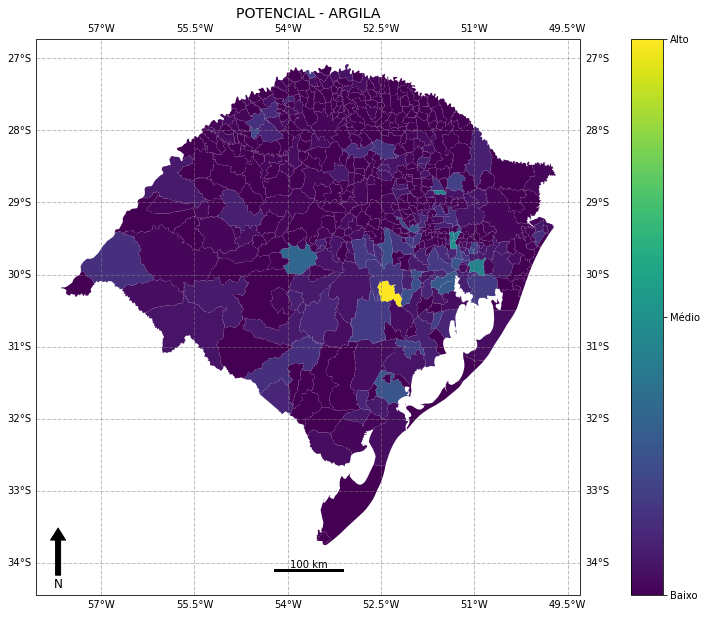

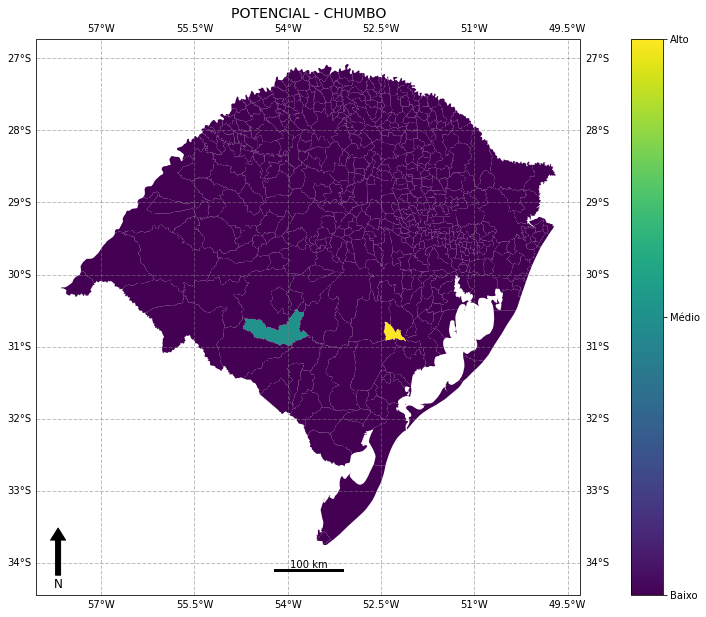

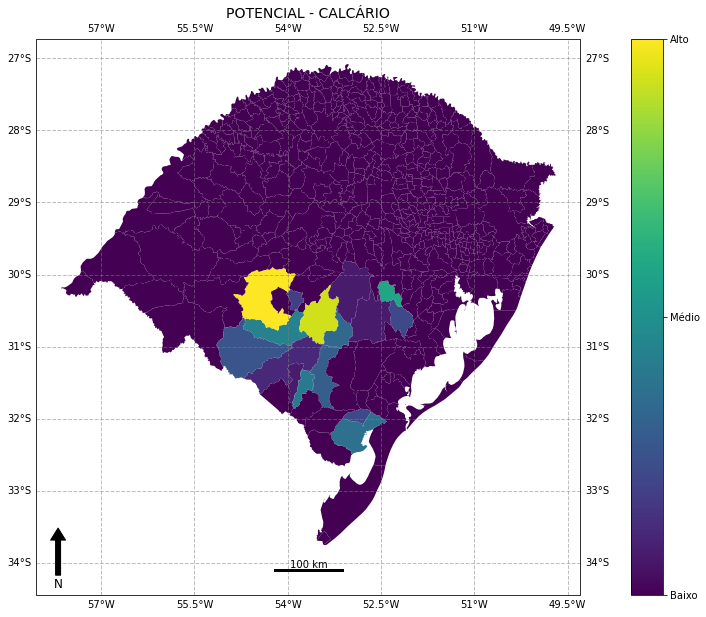

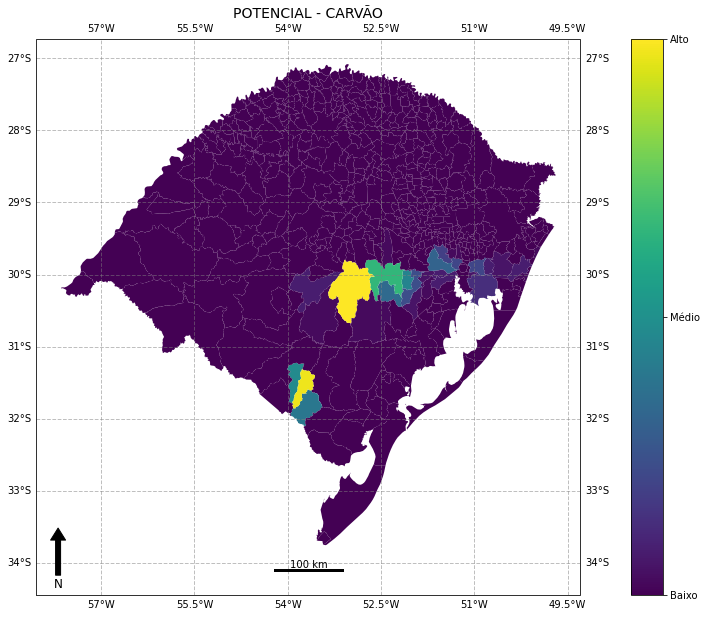

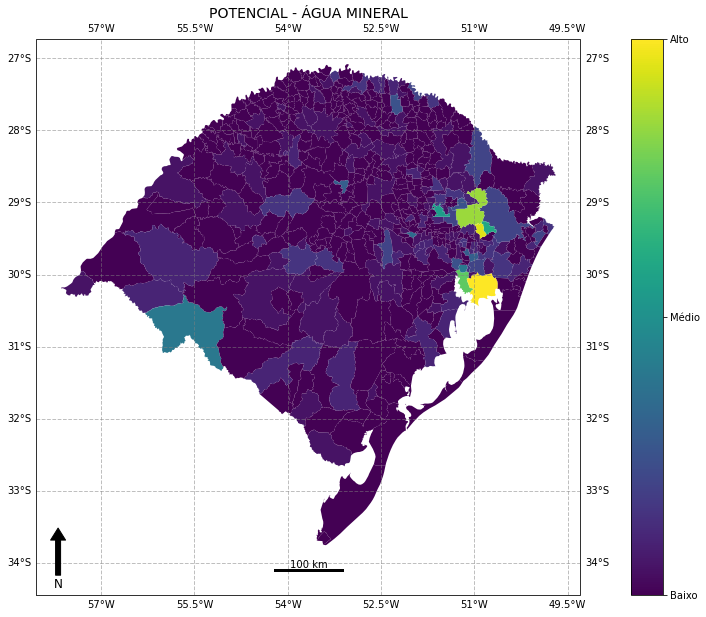

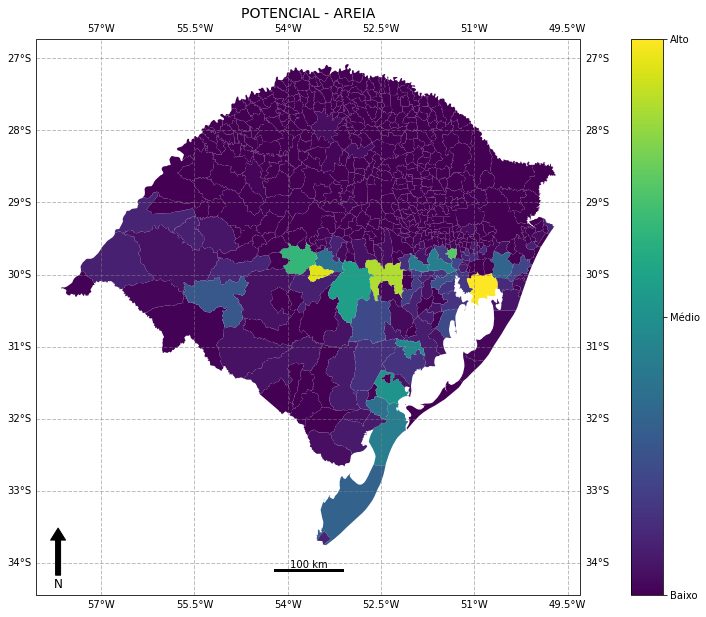

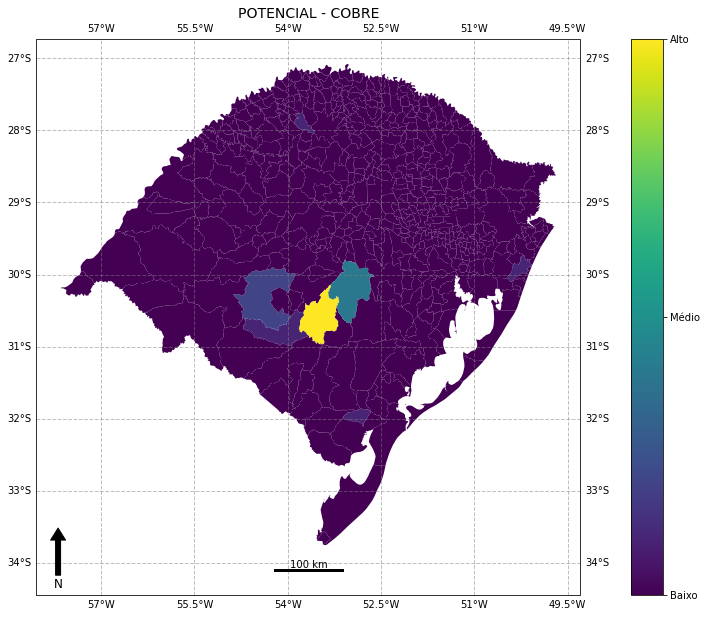

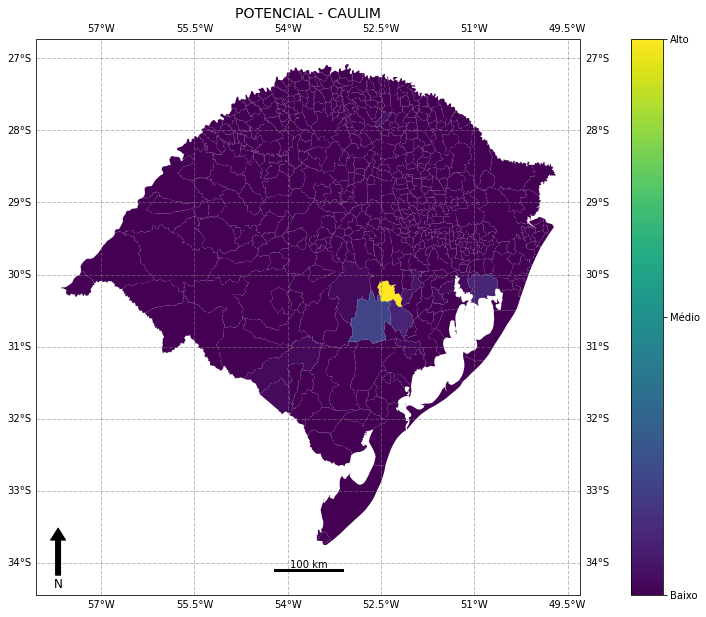

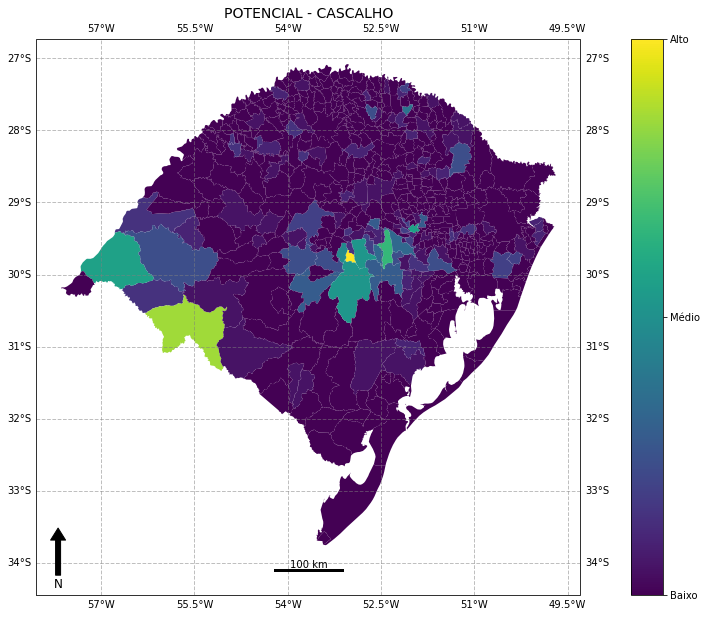

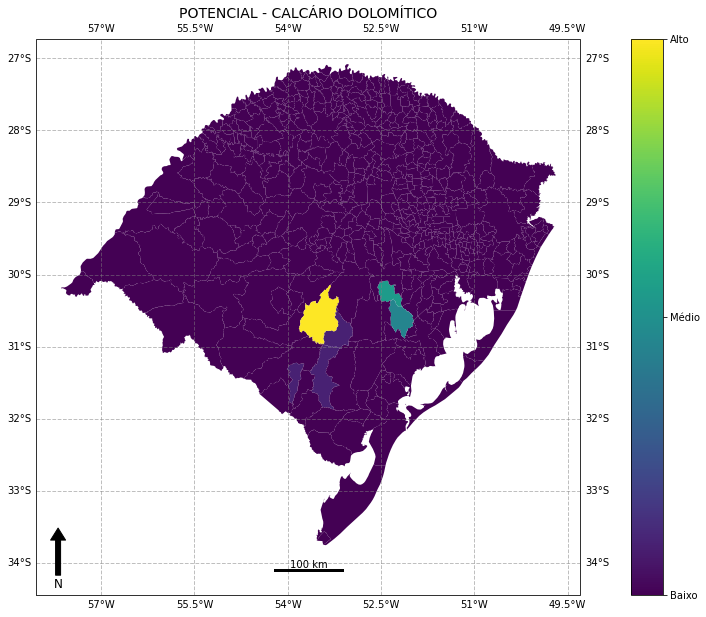

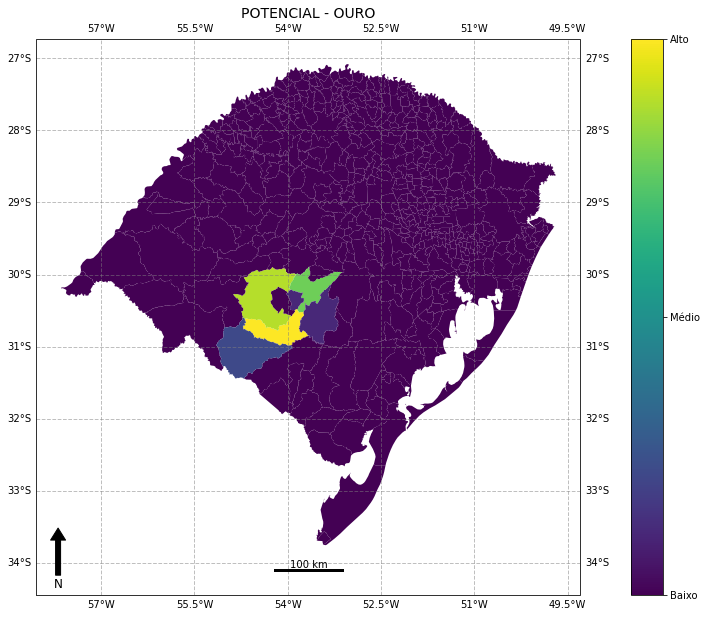

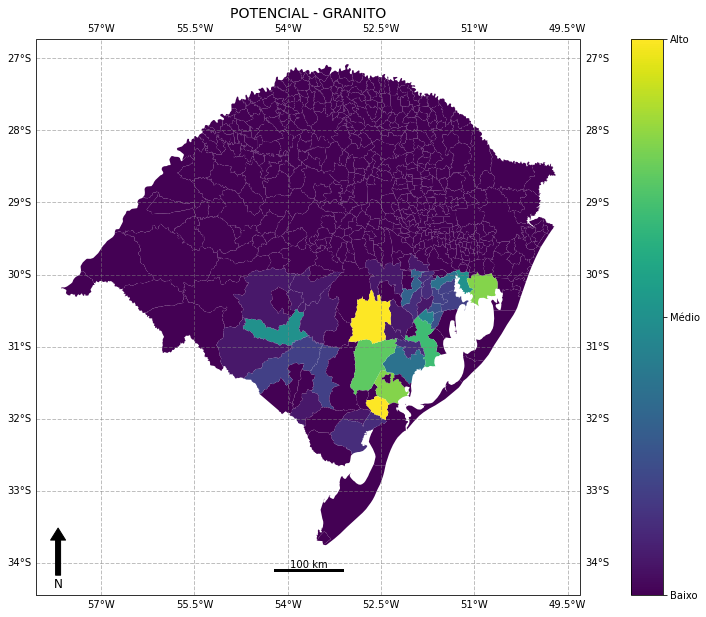

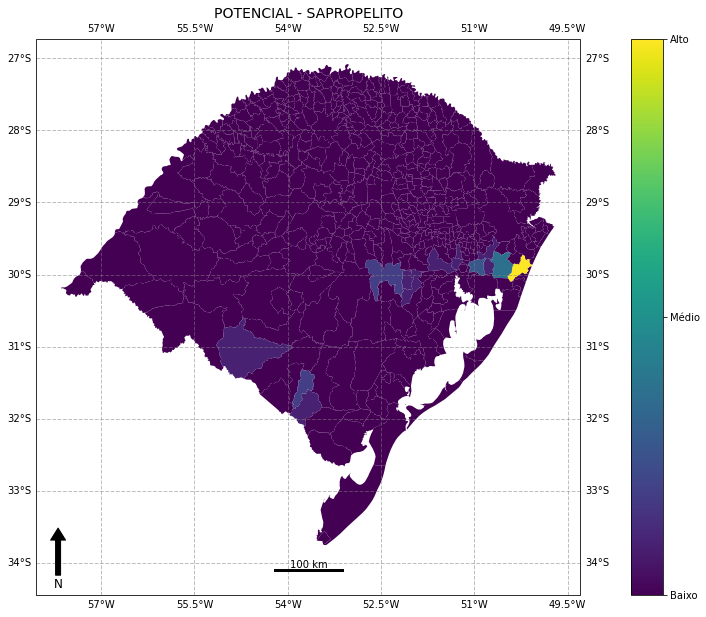

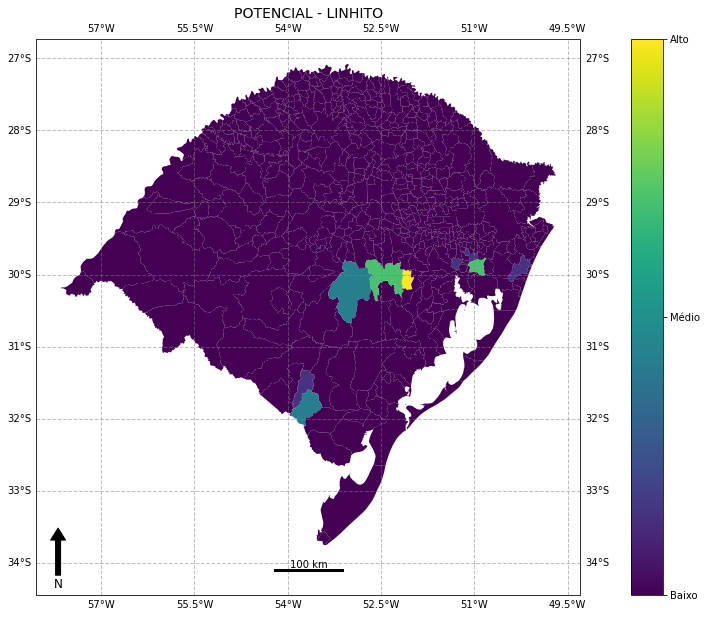

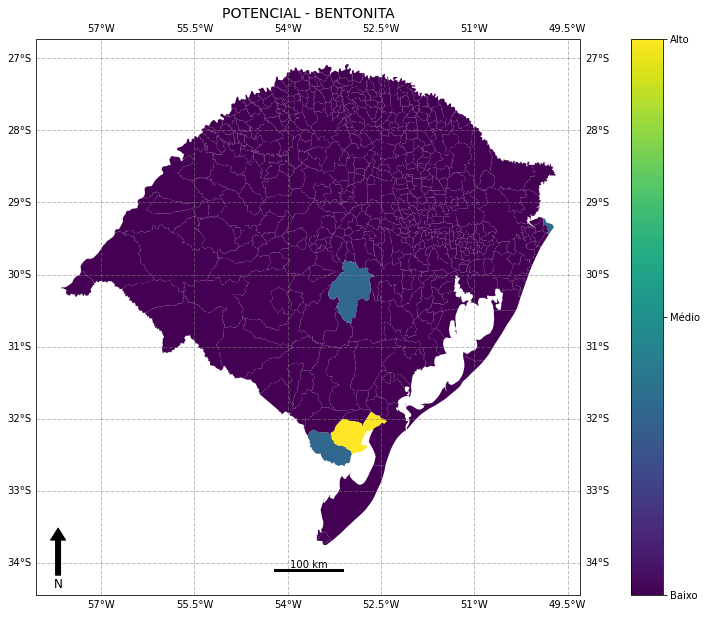

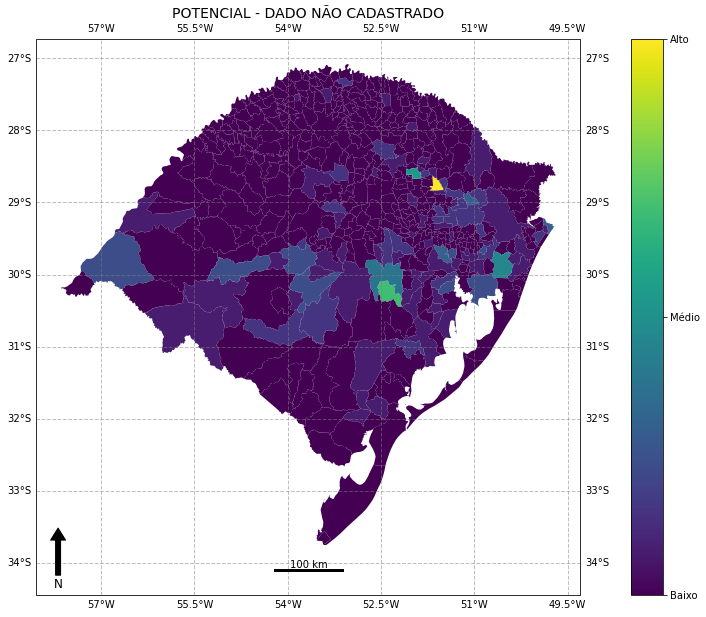

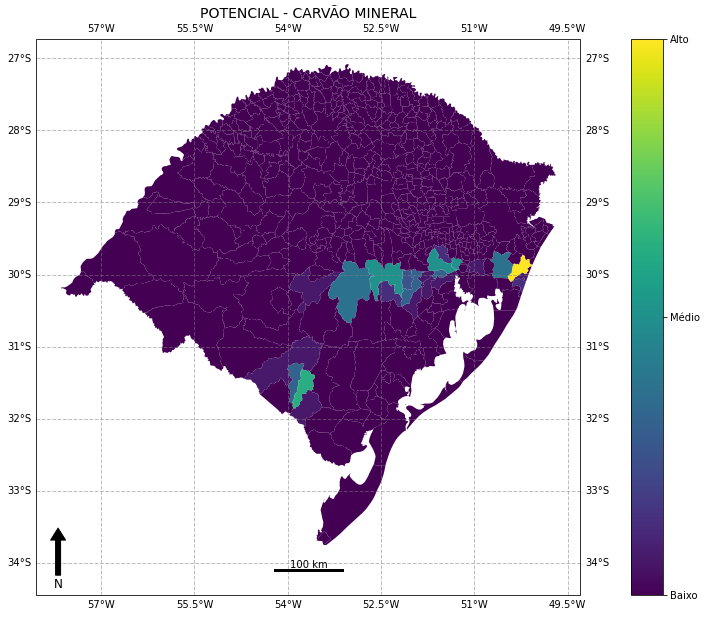

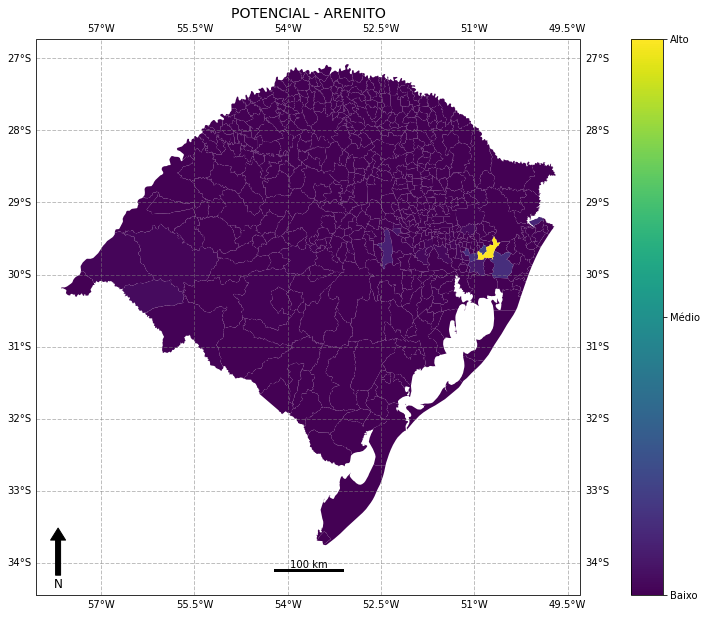

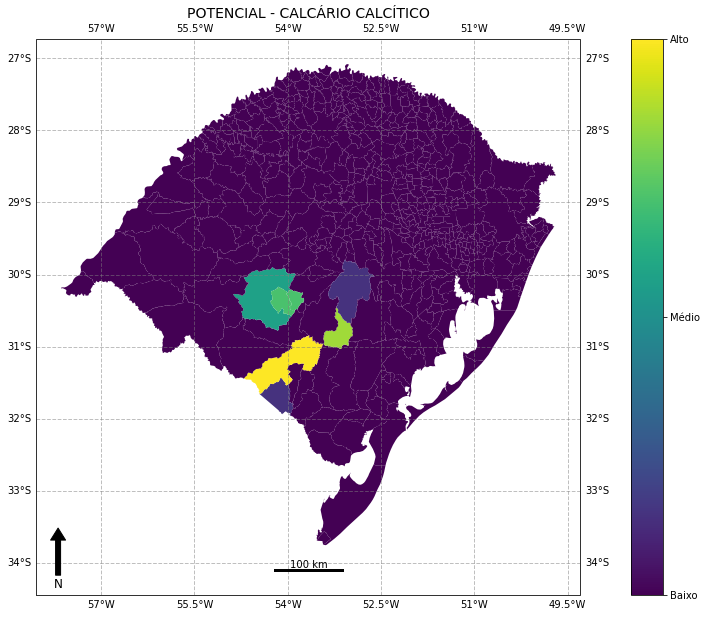

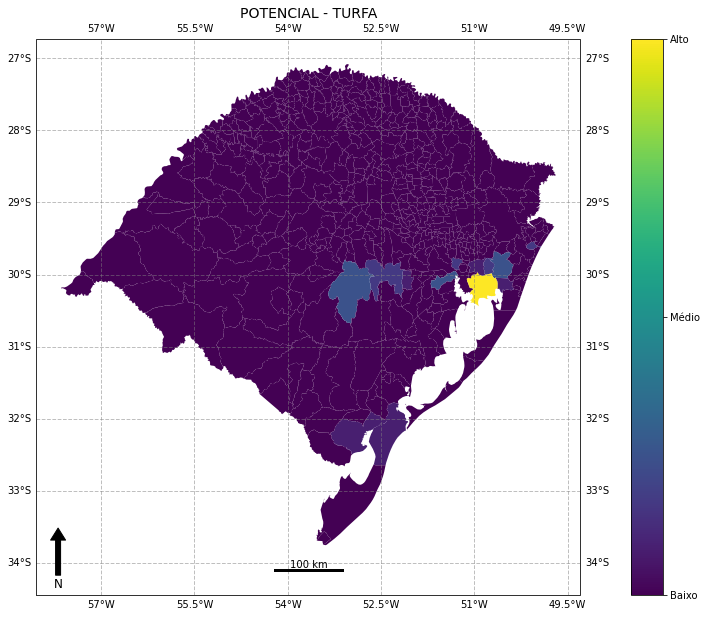

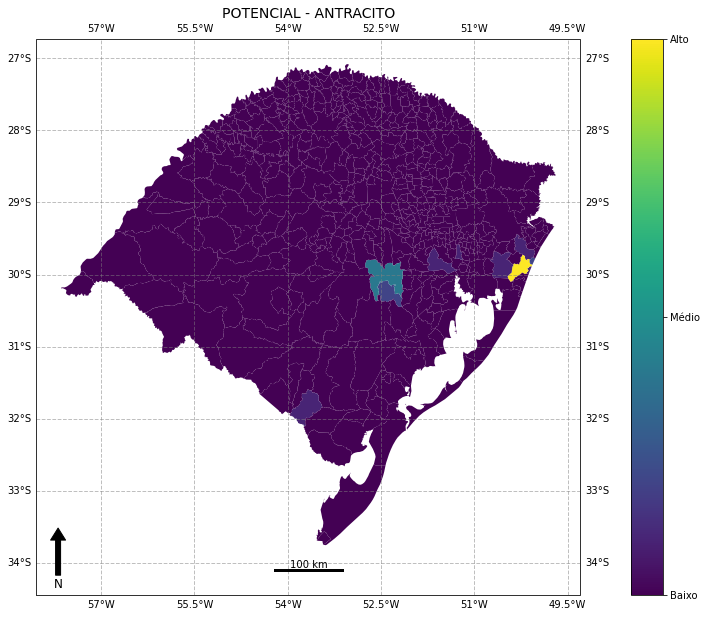

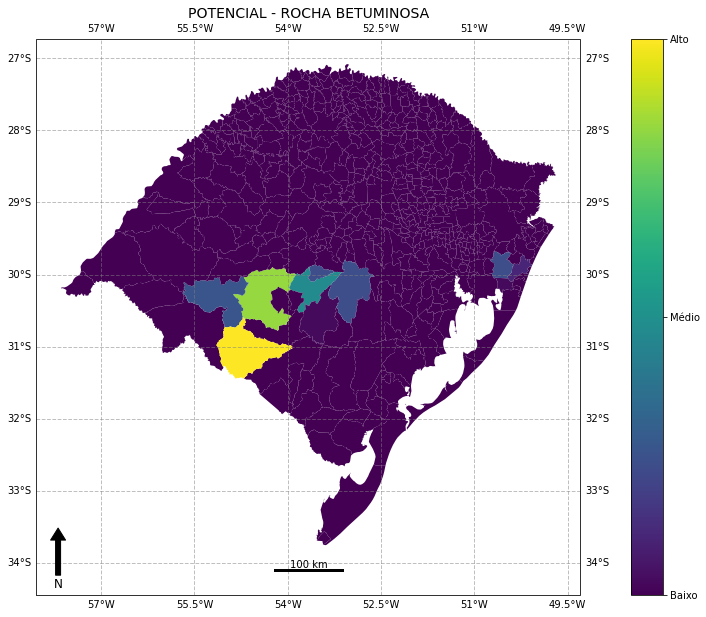

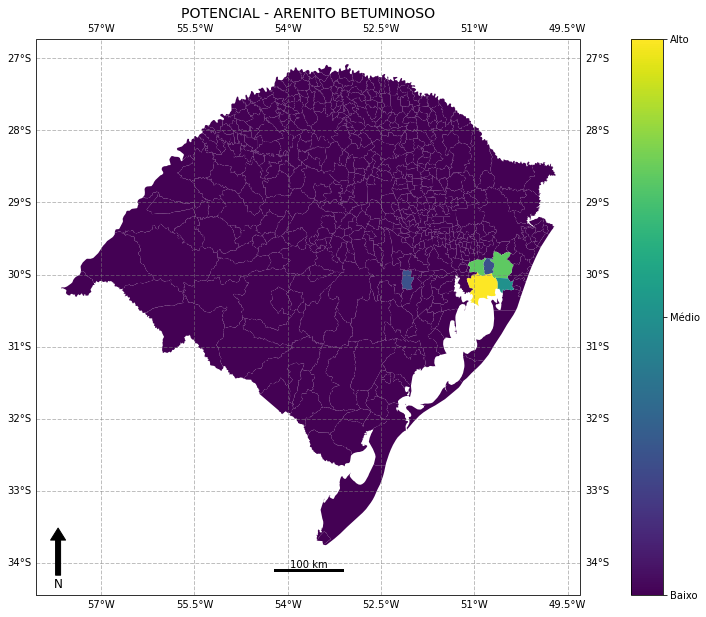

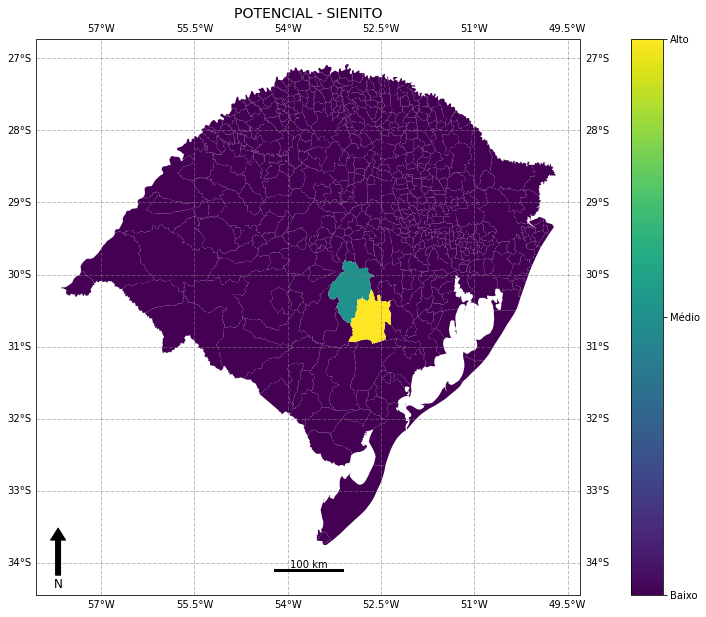

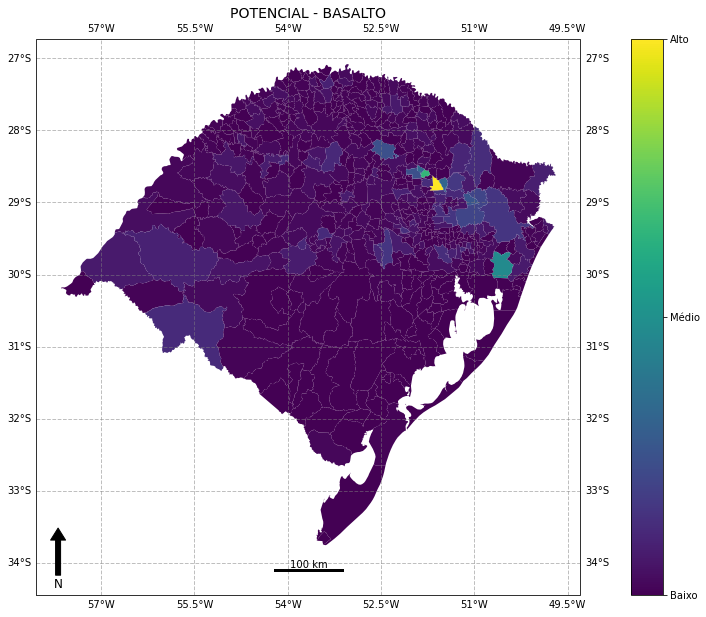

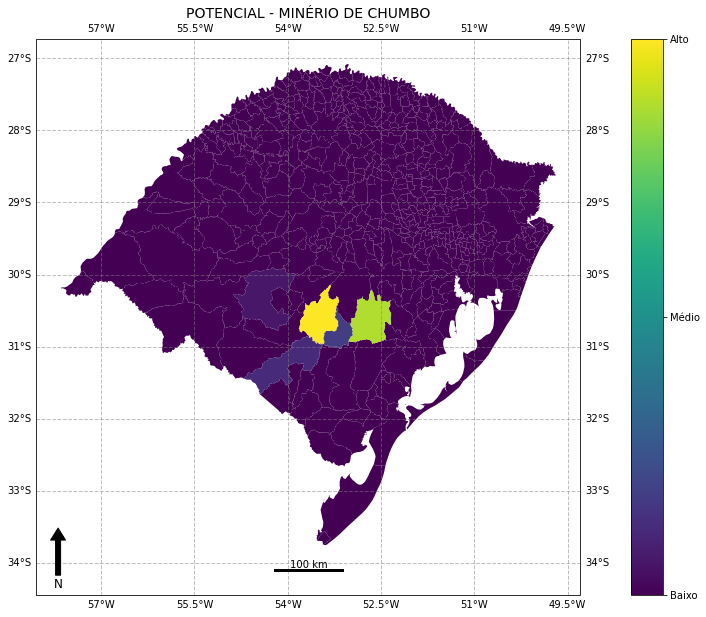

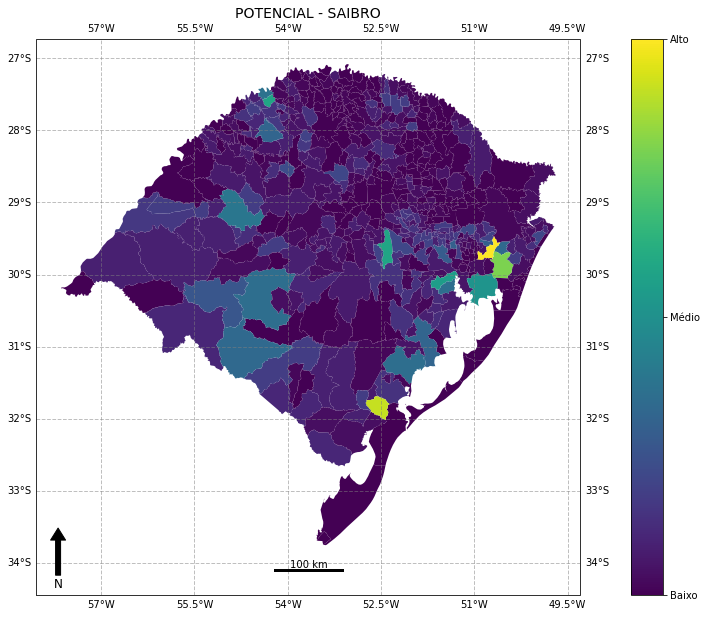

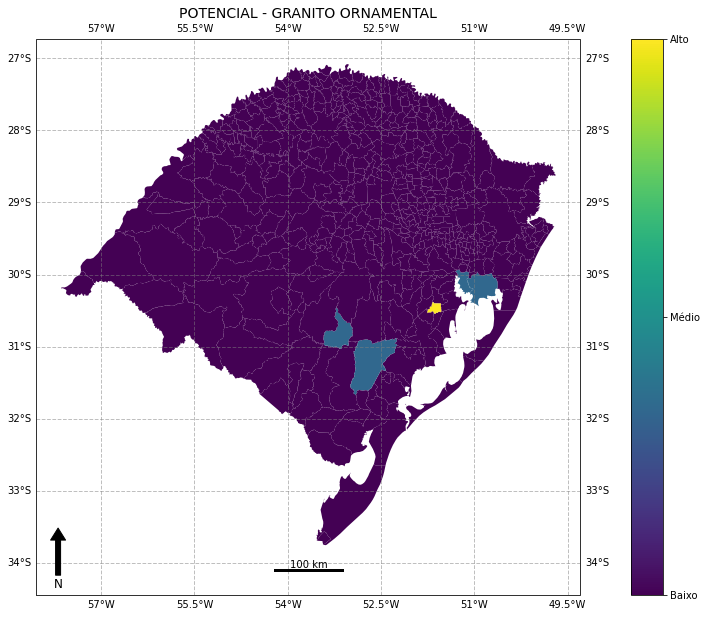

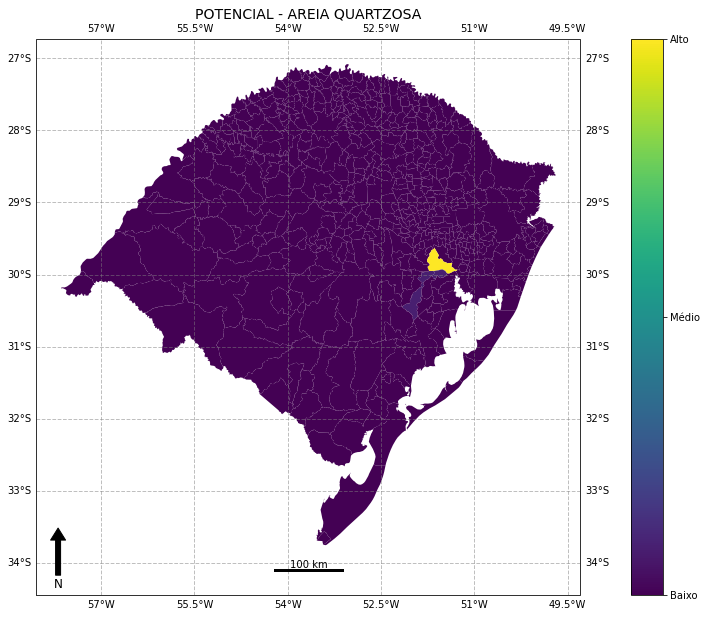

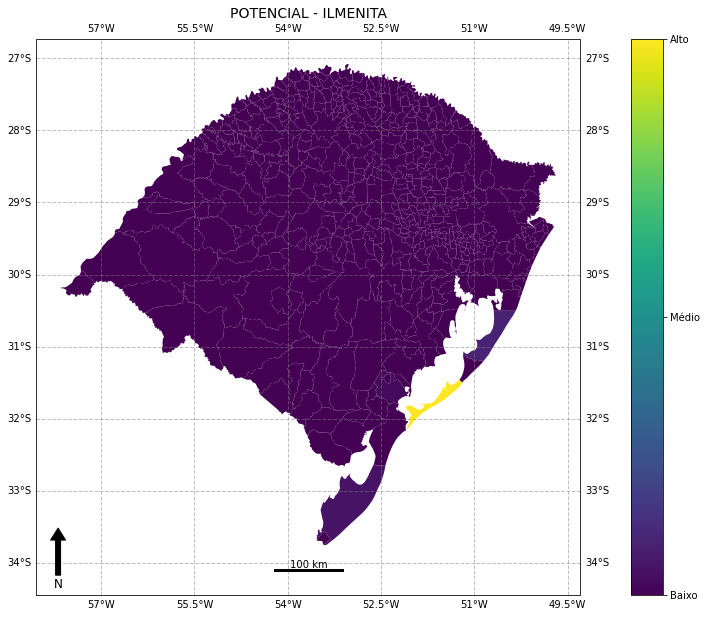

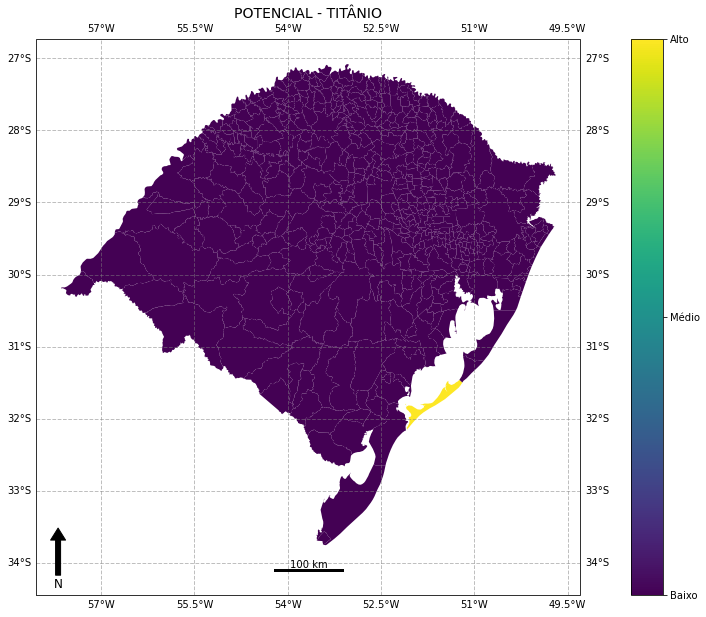

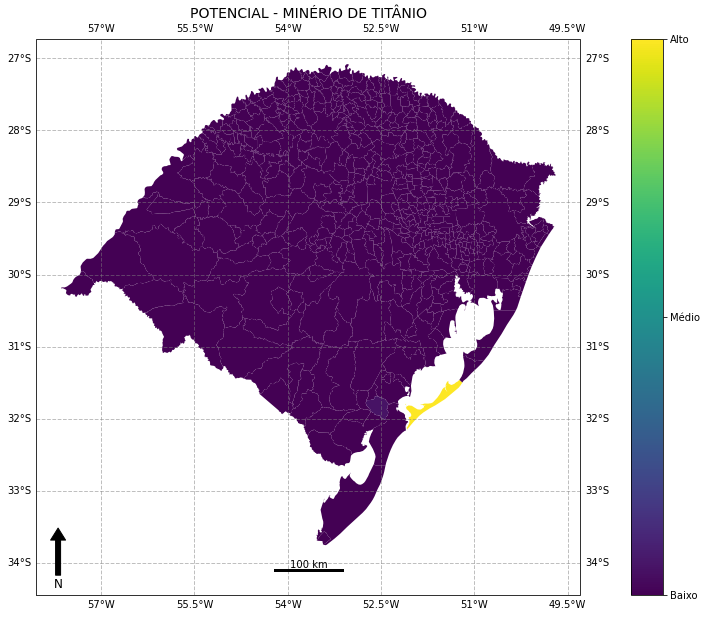

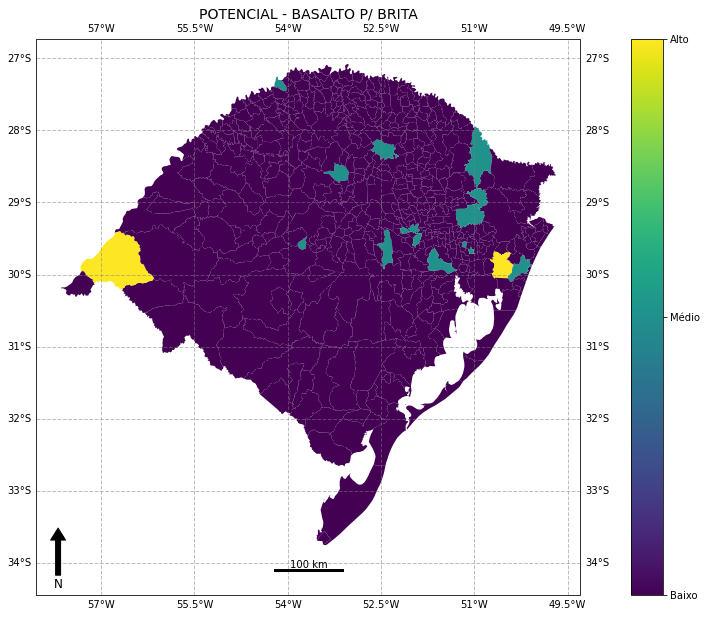

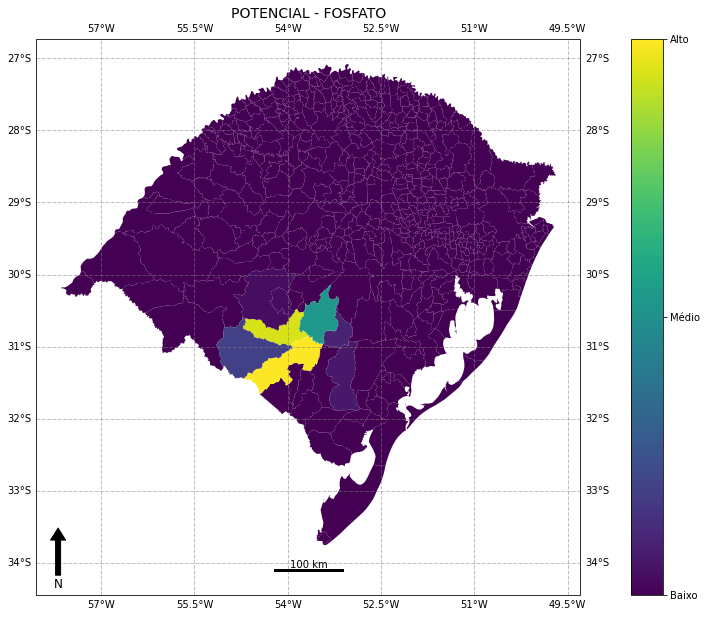

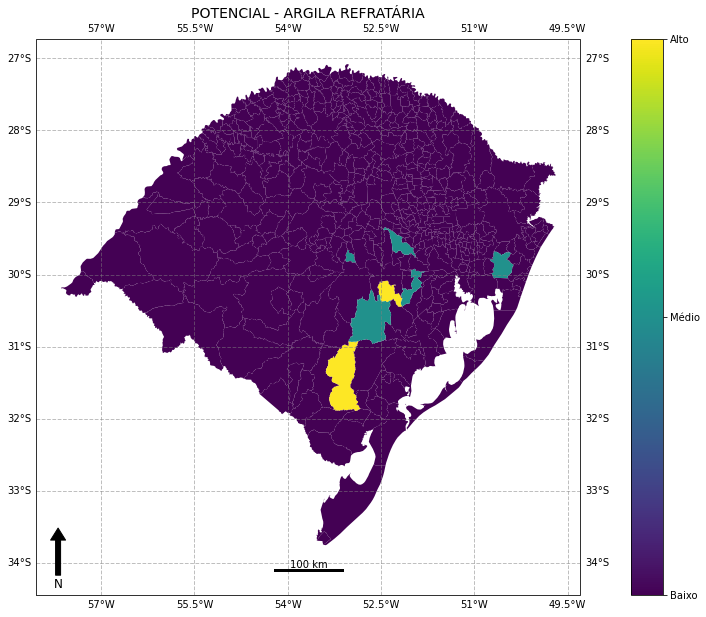

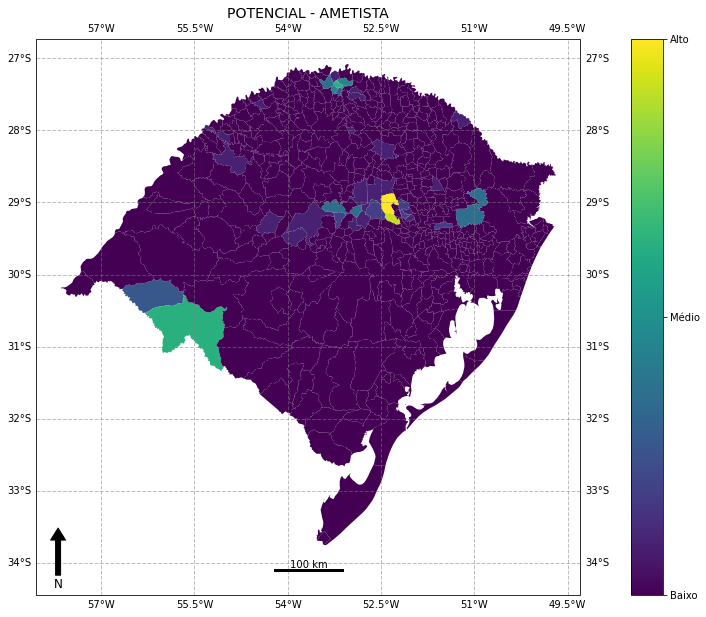

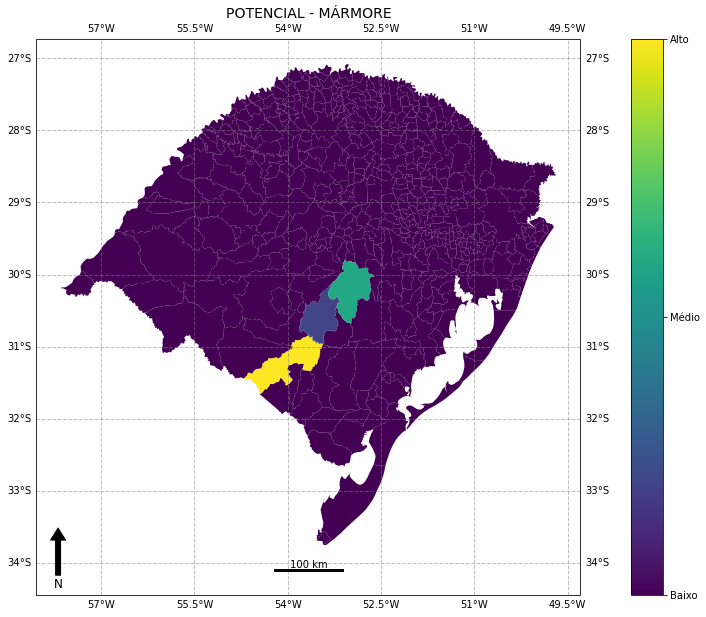

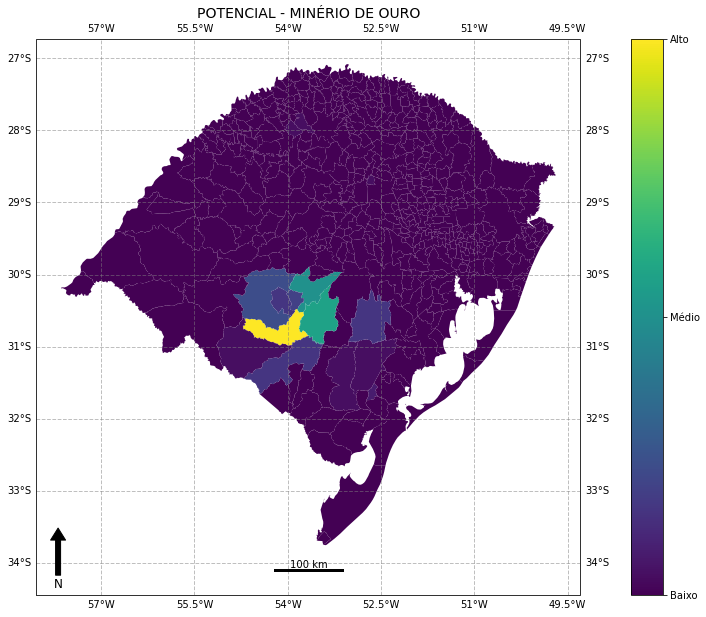

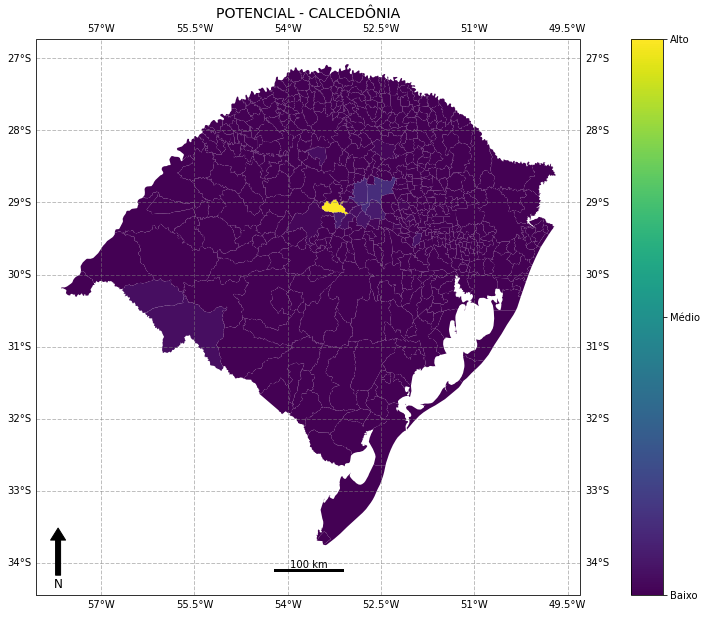

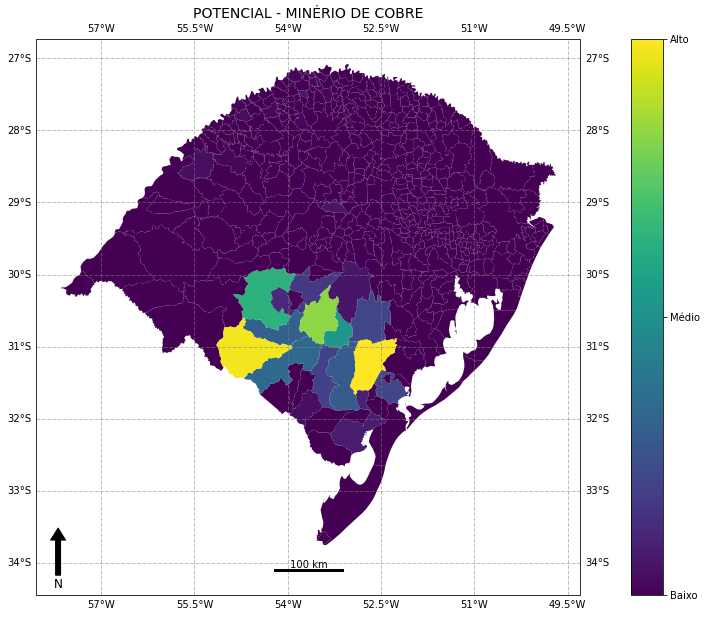

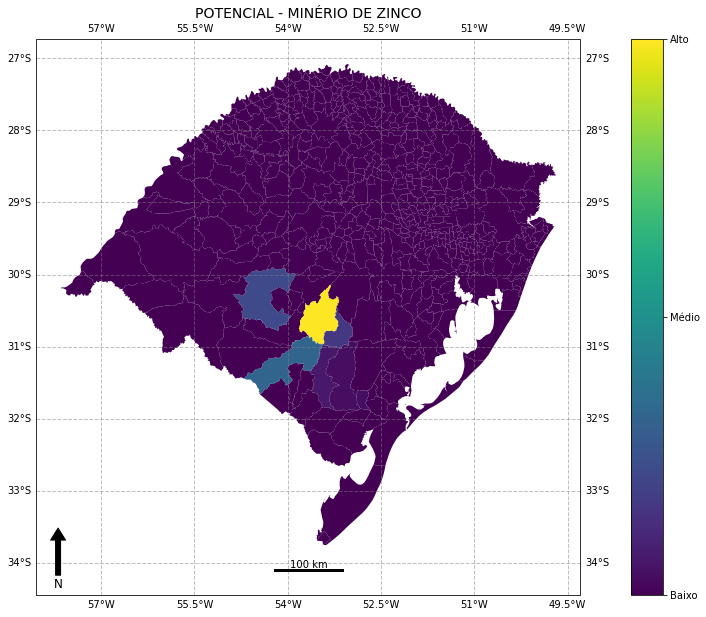

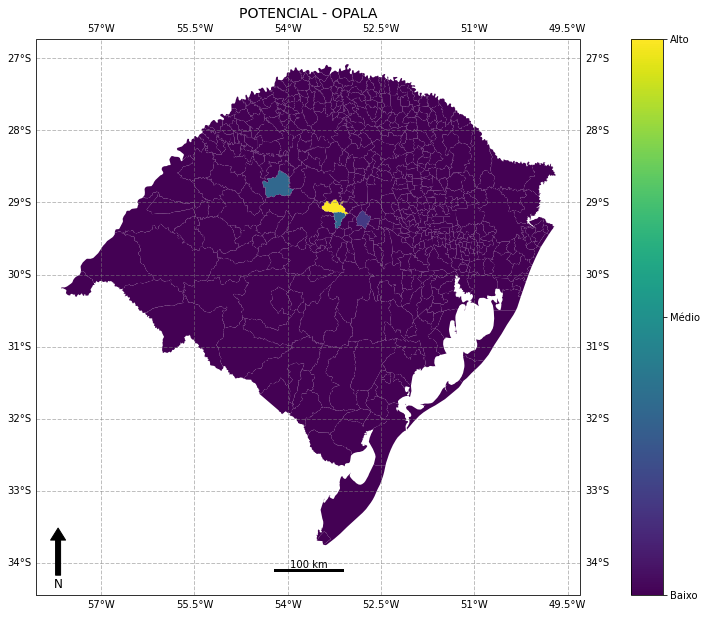

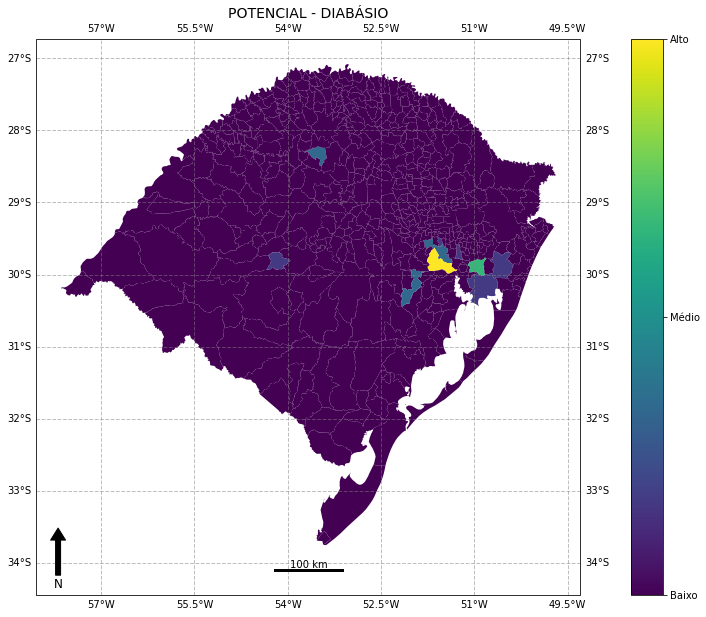

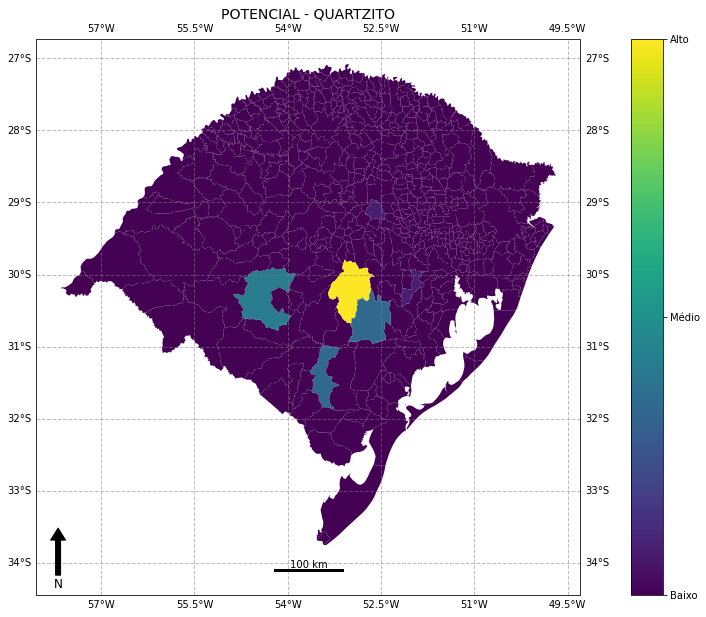

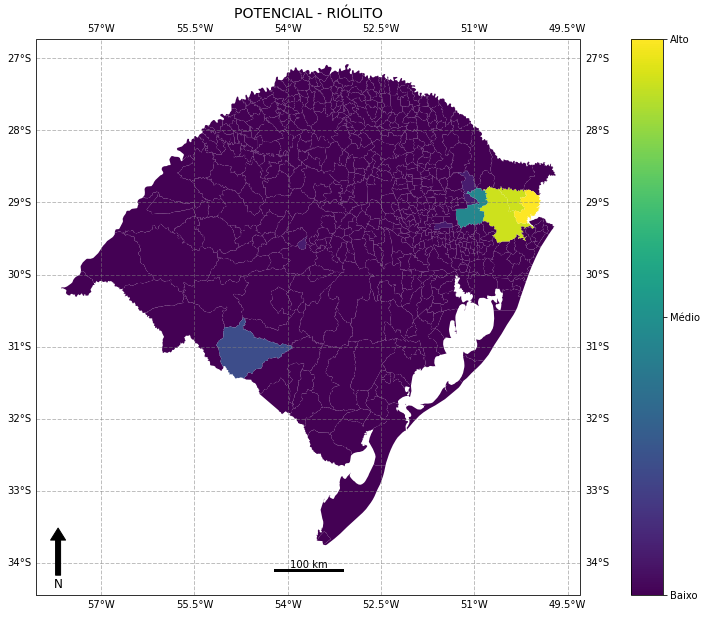

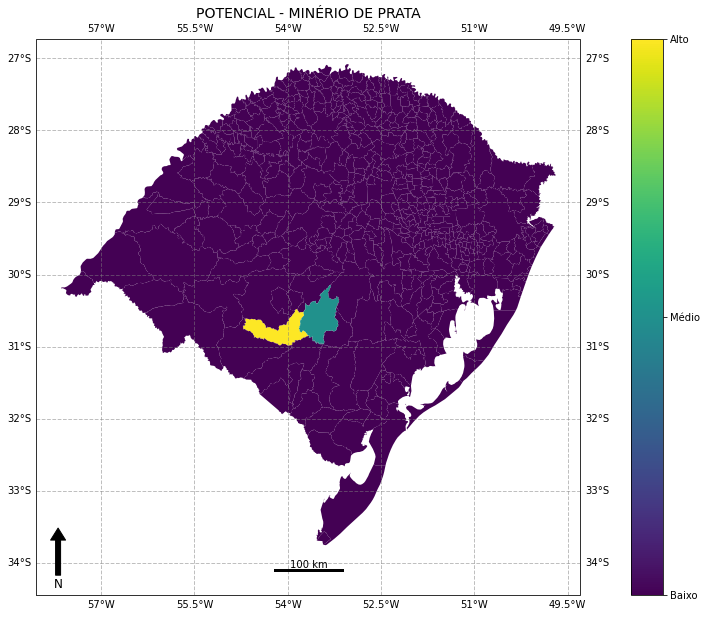

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for mineral in minerais:
    if np.sum(municipios[mineral].values) > 5:
        fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
        municipios.plot(ax=ax, column=mineral, legend=False)

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')

        divider = make_axes_locatable(ax)
        ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
        vmax = municipios[mineral].values.max()
        mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=100))
        fig.add_axes(ax_cb)
        cbar = fig.colorbar(mappable, cax=ax_cb, ticks=[0, 50, 100])
        cbar.ax.set_yticklabels(['Baixo', 'Médio', 'Alto'])

        x, y, arrow_length = 0.04, 0.12, 0.1
        ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
        arrowprops=dict(facecolor='black', width=5, headwidth=15),
        ha='center', va='center', fontsize=12,
        xycoords=ax.transAxes)

        scale_bar(ax, 100, location=(0.5,0.01))

        ax.set_title('POTENCIAL - {}'.format(mineral), loc='center', fontsize='14')
        nome = mineral.replace('/', '')
        plt.savefig('imagens/'+nome+".png", bbox_inches='tight', facecolor='white', dpi = 300)
        #plt.show()